In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from matplotlib.pyplot import figure
from numpy.random import choice



In [2]:
df = pd.read_json('dataset.json')

In [3]:
# sample_size = 1000 # samples per year number # small file
sample_size = 1500 # samples per year number # big file
chunk_size = 2000 # num of words in each sample NOTE: must be same as in ingest.py script
text_ratio_threshold = 0.92 
# text_ratio_threshold = 0.13 
# text_length_cutoff_high = 500000 # size in characters # small file
text_length_cutoff_high = 1000000 # size in characters # big file
text_length_cutoff_low = chunk_size * 5 # size in characters

def find_total_text(text):
    length = 0
    for chunk in text:
        length += len(chunk)
    return length


df['total_text_len'] = df['text'].apply(find_total_text)


# exclude values outside of threshold
df = df[df['text_ratio'] > text_ratio_threshold]
df = df[df['total_text_len'] < text_length_cutoff_high]
df = df[df['total_text_len'] > text_length_cutoff_low]


In [4]:
# explode chunks of 'chunk_size'
df = df.explode('text')
df = df.reset_index(drop=True)
df['text_len_characters'] = df['text'].apply(len)

In [5]:
# discard chunks with smaller text length
df['text_len_words'] = df['text'].apply(lambda text: len(text.split())) # dont store splits because of memory constraints (64GB not enough xD)
df = df[df['text_len_words'] == chunk_size]

In [6]:
df = df.drop('total_text_len', axis=1).drop('text_len_words', axis=1)

In [7]:
# calculate sampling weights, so that long titles are not favoured in the distribution

title_counter = {}

for row in df.iterrows():
    title = row[1]['title'] + row[1]['author'] + str(row[1]['date'])
    if title in title_counter:
        title_counter[title] = title_counter[title] + 1
    else:
        title_counter[title] = 1

df['weights'] = df.apply(lambda row: title_counter[row['title'] + row['author'] + str(row['date'])], axis=1)
df['weights'] = 1 / df['weights']


In [8]:
# take 'sample_size' samples from each year
df_uniform_sample = df.groupby('date', group_keys=False).apply(lambda group: group.sample(n=min(len(group), sample_size)))
df_weighted_sample = df.groupby('date', group_keys=False).apply(lambda group: group.sample(n=min(len(group), sample_size), weights=group['weights']))




# def sample_weighted(group):
#     total_weights = group['weights'].sum()
    
#     group['weights'] = group['weights'] / total_weights
#     s = choice(a=group.index, size=min(sample_size, len(group)), replace=False, p = group['weights'])
    
#     return group.loc[s]



# df_weighted_sample = df.groupby('date', group_keys=False).apply(sample_weighted)




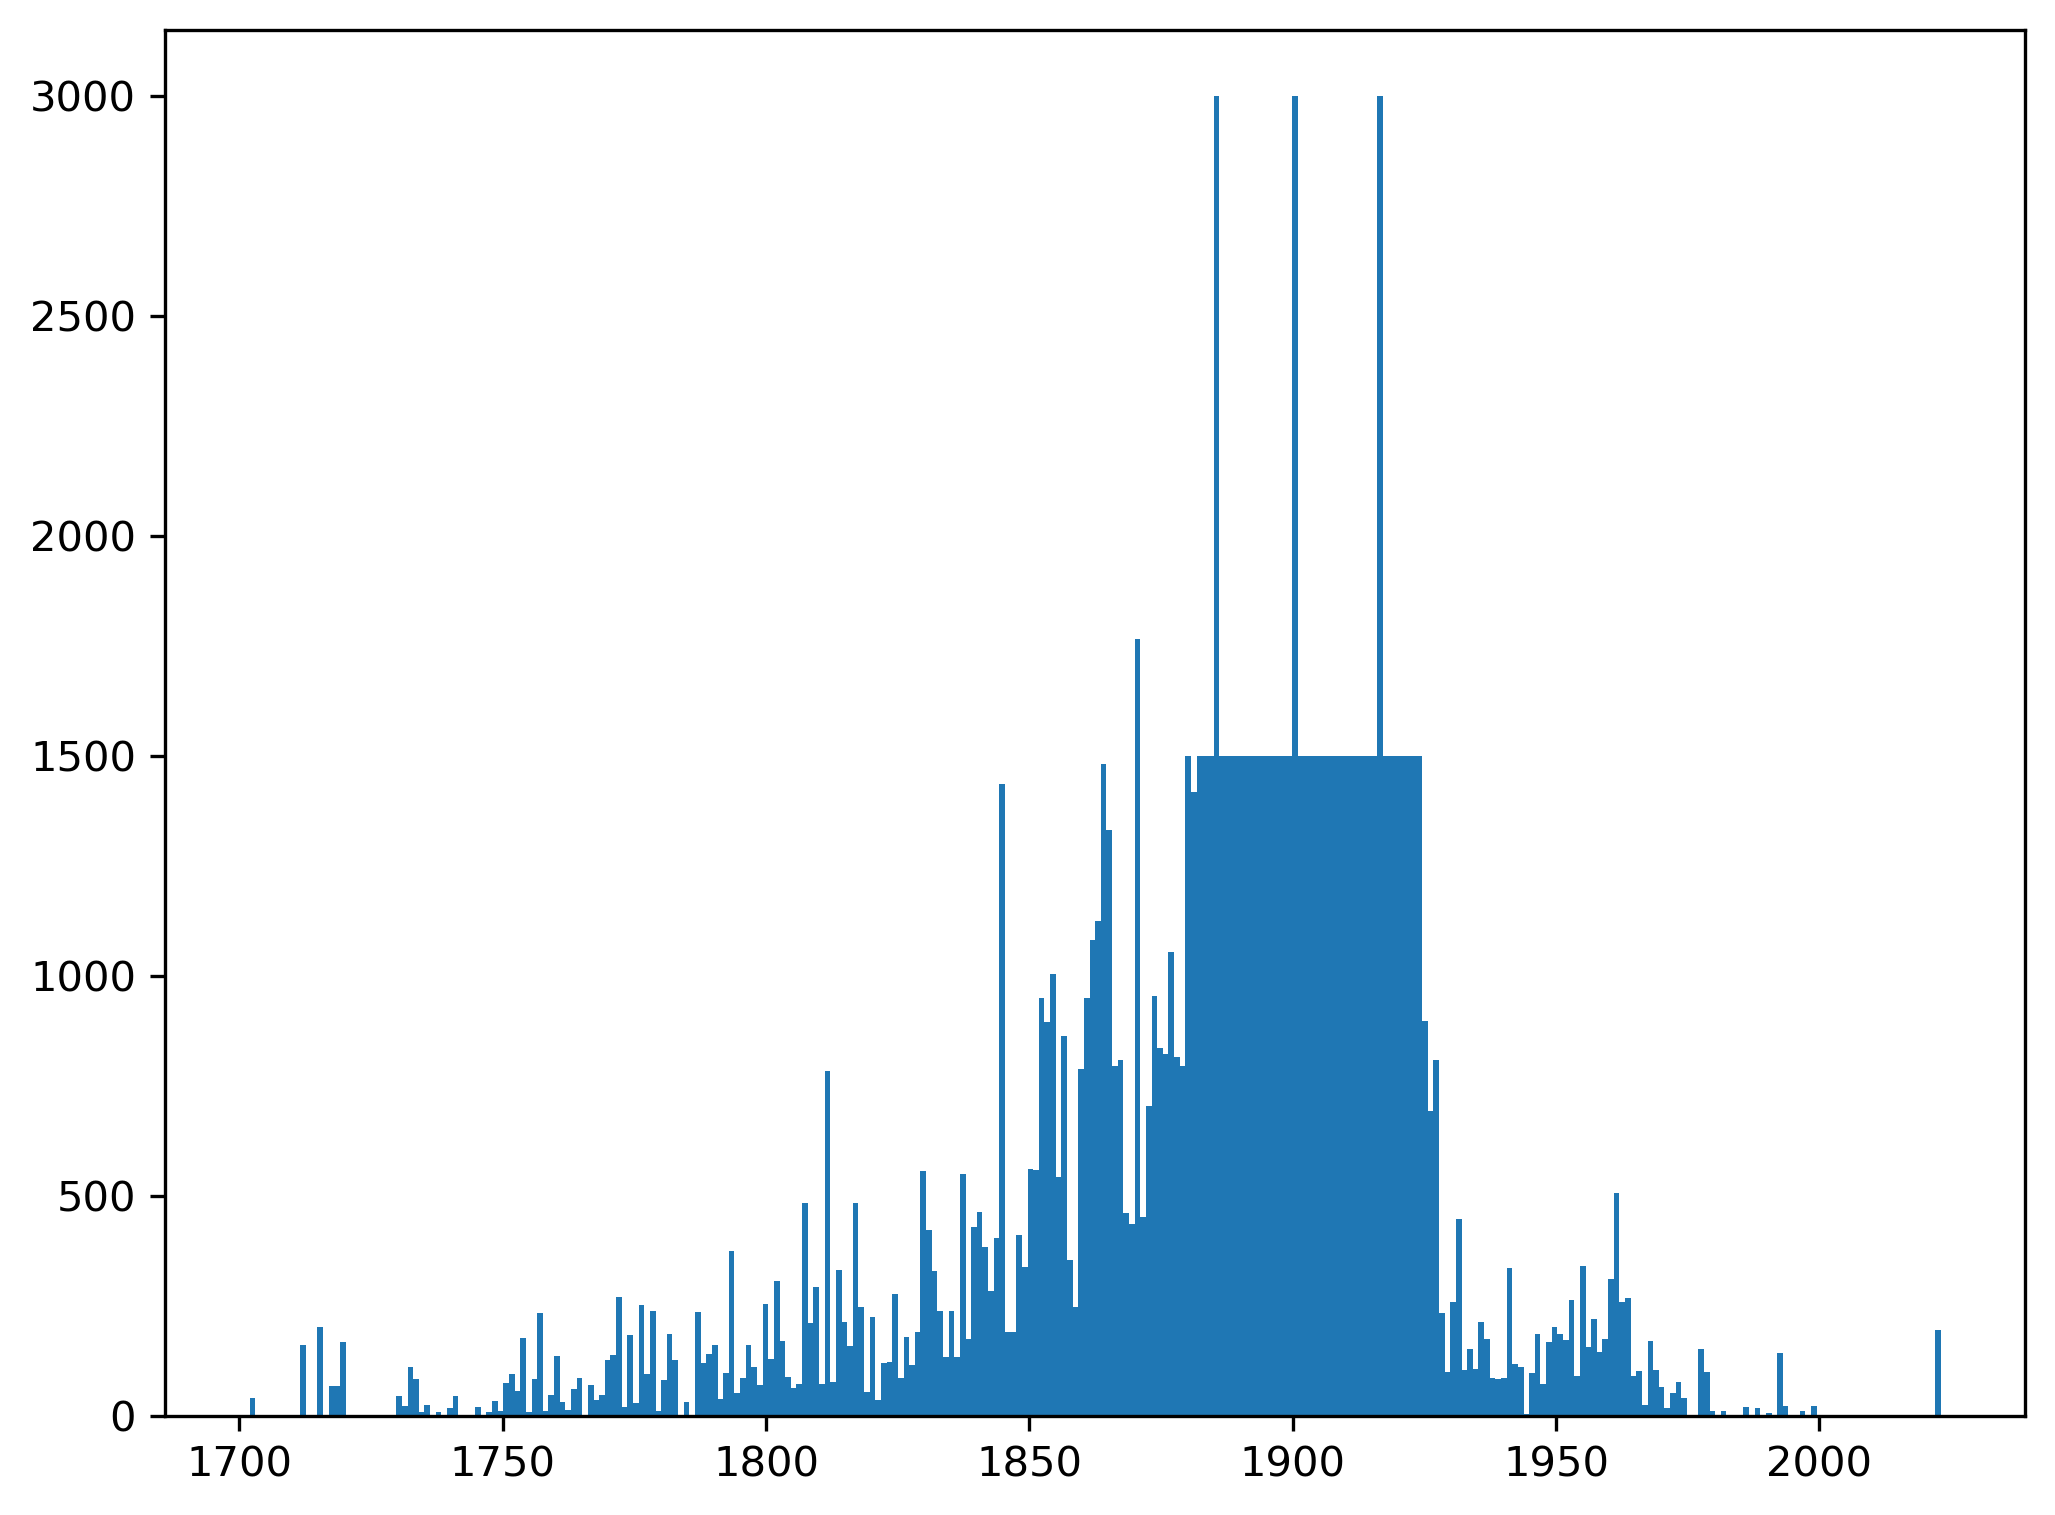

In [9]:
figure(figsize=(8, 6), dpi=300)

plt.hist(df_weighted_sample['date'], bins=300)
plt.show()


In [10]:
df_weighted_sample

,title,author,date,text_ratio,text,text_len_characters,weights
273901,"Historical Record of the Thirty-fourth, or the...",Richard Cannon,1702,0.944455,in numbers to three thousand five hundred menr...,12139,0.111111
273902,"Historical Record of the Thirty-fourth, or the...",Richard Cannon,1702,0.944455,joseph bonaparte titular king of spain at tala...,12133,0.111111
129008,The Memorable Thoughts of Socrates,Xenophon,1702,0.963115,in war only to secure their own quiet and choo...,10511,0.047619
273905,"Historical Record of the Thirty-fourth, or the...",Richard Cannon,1702,0.944455,the honorable henry seymour conway appointed t...,11779,0.111111
273899,"Historical Record of the Thirty-fourth, or the...",Richard Cannon,1702,0.944455,improvements were eventually introduced in the...,11914,0.111111
...,...,...,...,...,...,...,...
306351,How music grew,Marion Bauer,2023,0.926967,plain song and airs from the cloister and yet ...,10948,0.016667
306335,How music grew,Marion Bauer,2023,0.926967,song and they brought over to britain all thei...,11399,0.016667
306365,How music grew,Marion Bauer,2023,0.926967,writing in that work which is typical of mende...,11409,0.016667
306333,How music grew,Marion Bauer,2023,0.926967,soon the composers made this melody in the med...,10598,0.016667


In [11]:
df_weighted_sample.to_json('better-dataset.json')

In [12]:
weighted_sample_counter = {}
uniform_sample_counter = {}

for row in df_weighted_sample.iterrows():
    title = row[1]['title'] + row[1]['author'] + str(row[1]['date'])
    if title in weighted_sample_counter:
        weighted_sample_counter[title] = weighted_sample_counter[title] + 1
    else:
        weighted_sample_counter[title] = 1

for row in df_uniform_sample.iterrows():
    title = row[1]['title'] + row[1]['author'] + str(row[1]['date'])
    if title in uniform_sample_counter:
        uniform_sample_counter[title] = uniform_sample_counter[title] + 1
    else:
        uniform_sample_counter[title] = 1


sdf = pd.read_json('dataset.json')

sdf['weighted'] = sdf.apply(lambda row: weighted_sample_counter[row['title'] + row['author'] + str(row['date'])] if (row['title'] + row['author'] + str(row['date'])) in weighted_sample_counter else 0, axis=1)
sdf['uniform'] = sdf.apply(lambda row: uniform_sample_counter[row['title'] + row['author'] + str(row['date'])] if (row['title'] + row['author'] + str(row['date'])) in uniform_sample_counter else 0, axis=1)

sdf['weights'] = sdf.apply(lambda row: title_counter[row['title'] + row['author'] + str(row['date'])] if (row['title'] + row['author'] + str(row['date'])) in title_counter else 0, axis=1)

In [13]:
bdf = sdf.sort_values(by='weighted')

In [14]:
bdf.tail(10)

,title,author,date,text_ratio,text,weighted,uniform,weights
2691,Our Vanishing Wild Life: Its Extermination and...,William T. Hornaday,1857,0.954692,[our vanishing wild life its extermination and...,86,86,86
2392,A Voyage to Terra Australis — Volume 2 / Under...,Matthew Flinders,1802,0.959353,[north head of bustard bay dist leagues s e ga...,86,86,86
12520,"The Journal of Speculative Philosophy, Vol. I,...",Various,1968,0.969176,[preface in concluding the first volume of thi...,86,86,86
7493,Whiteladies,Mrs. Oliphant,1875,0.961841,[chapter e verard austin remained at whiteladi...,86,86,86
5623,Christology of the Old Testament: And a Commen...,Ernst Wilhelm Hengstenberg,1856,0.939175,[light is the image of salvation to walk in th...,88,88,88
563,The Kellys and the O'Kellys,Anthony Trollope,1848,0.953738,[chapter i the trial during the first two mont...,88,88,88
1727,"Cameos from English History, from Rollo to Edw...",Charlotte M. Yonge,1873,0.965358,[cameo youth of the conqueror kings of england...,89,89,89
4611,"John Marchmont's Legacy, Volumes 1-3",M. E. Braddon,1863,0.964257,[psthen comes what the lawyers call a general ...,90,90,90
9077,The Red and the Black: A Chronicle of 1830,Stendhal,1830,0.967604,[the author was sublieutenant in the th dragoo...,90,90,90
1653,Barchester Towers,Anthony Trollope,1857,0.964695,[chapter v a morning visit it was known that p...,91,91,91


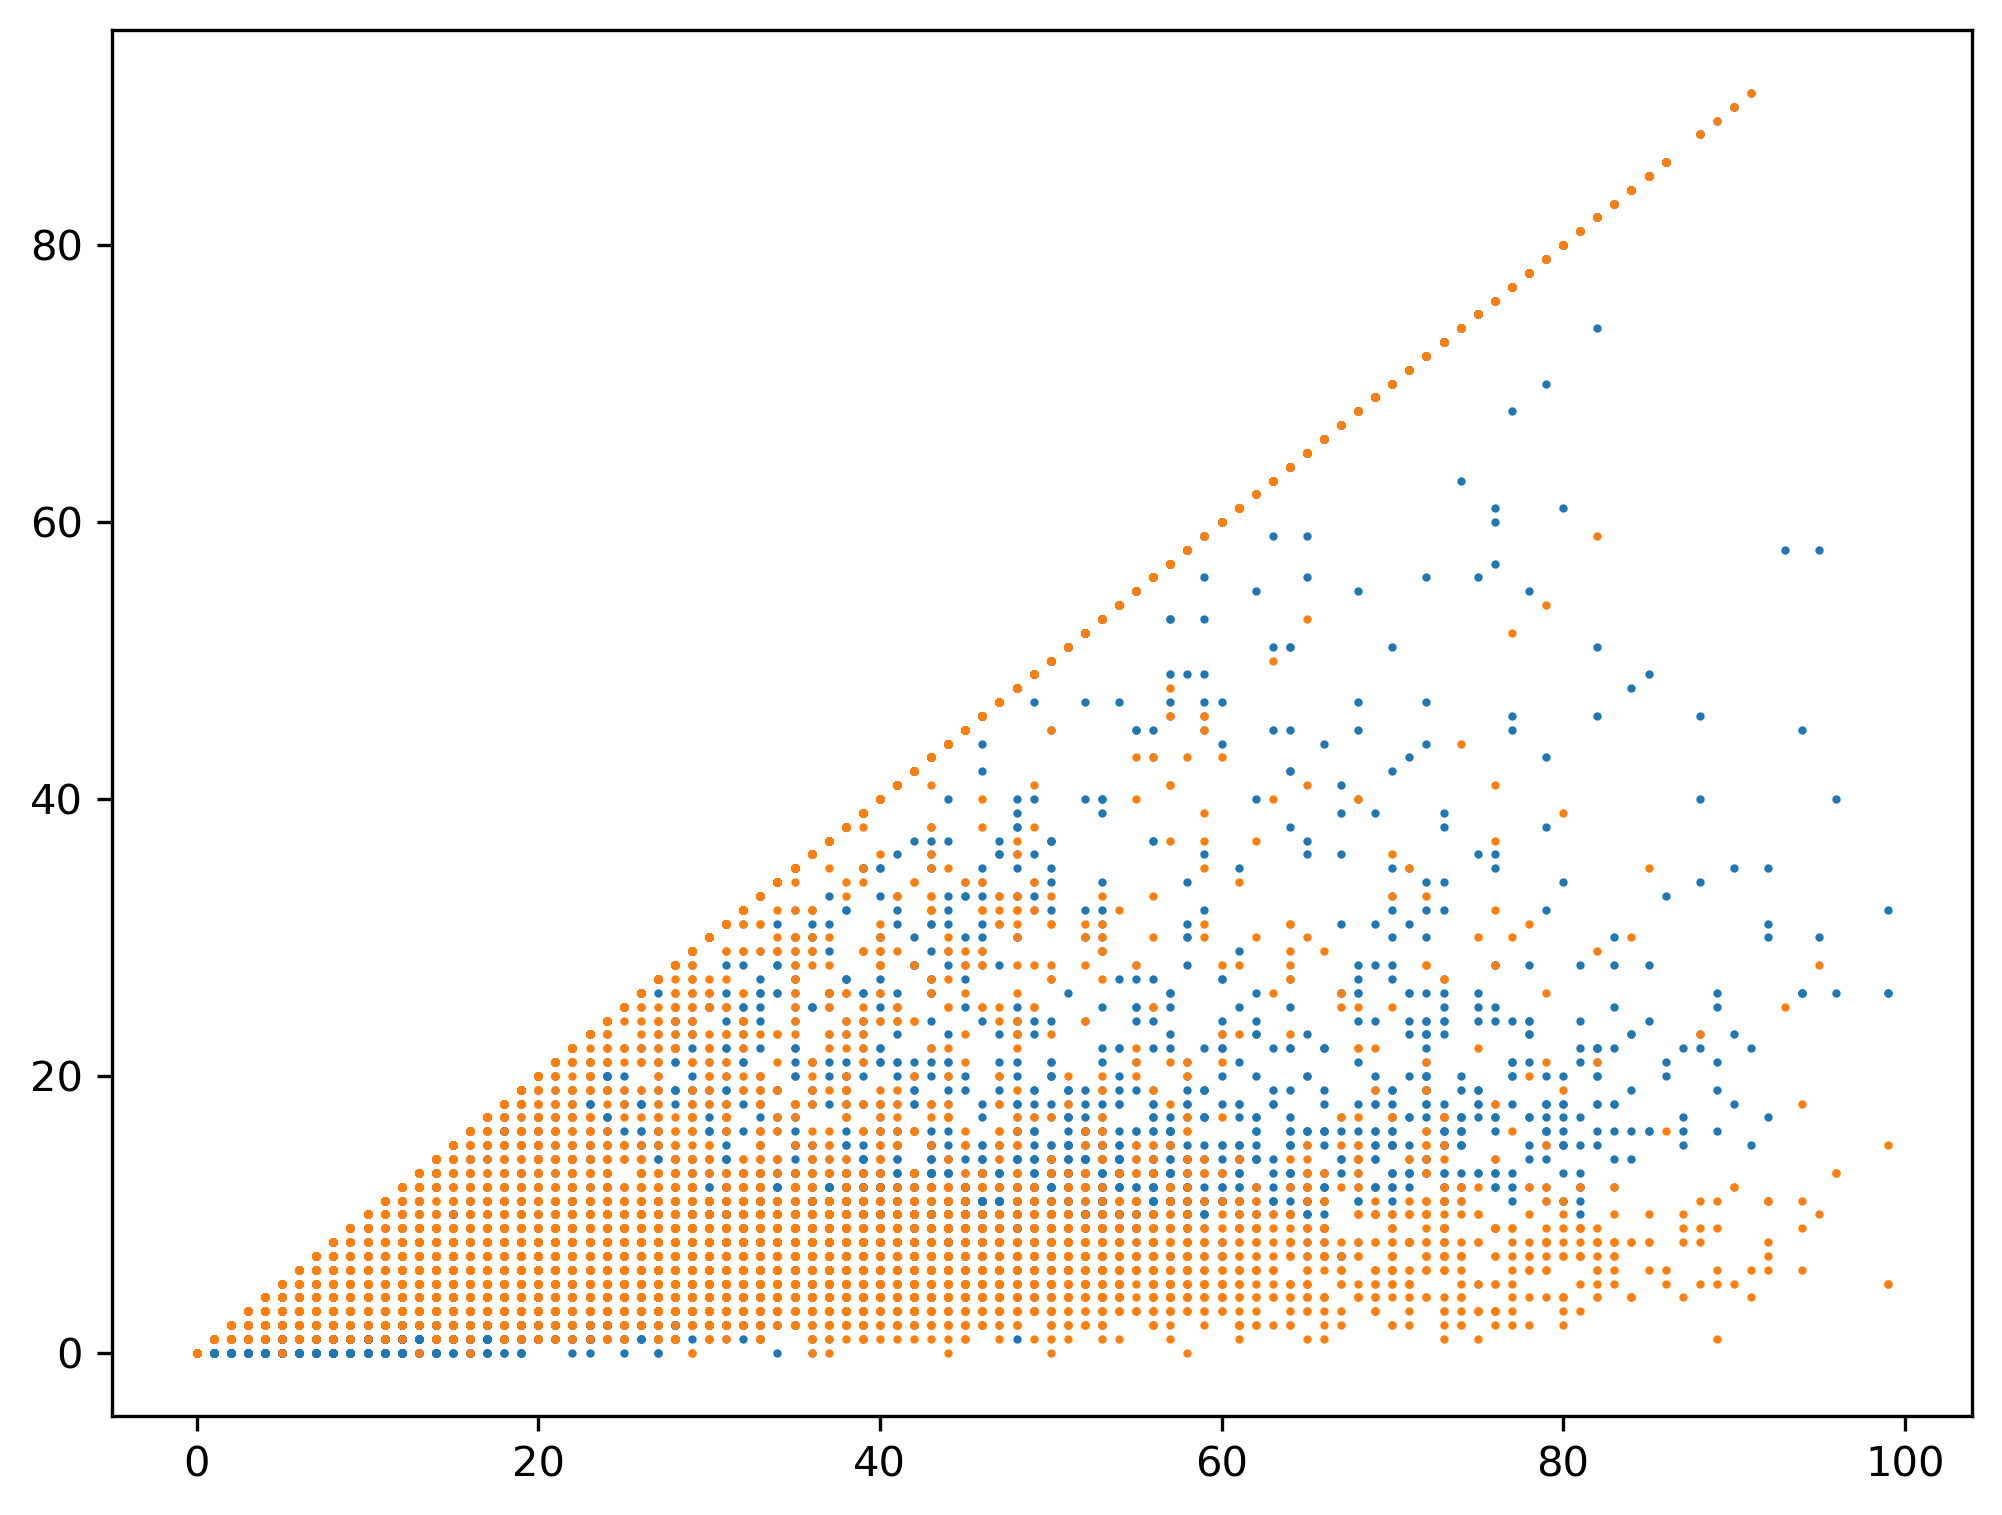

In [15]:

figure(figsize=(8, 6), dpi=300)

#plt.hist(sdf['uniform'], color='red', bins = 500)
#plt.hist(sdf['weighted'], color='green', bins = 500)


# plt.show()

plt.scatter(sdf['weights'], sdf['uniform'], s=1)
plt.scatter(sdf['weights'], sdf['weighted'], s=1)
plt.show()

In [16]:
test = df.groupby('date', group_keys=False)

In [17]:
test